In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.2 MB/s eta 0:00:00


In [15]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.5 MB/s eta 0:00:00


In [17]:
!pip install bayesian-optimization

In [18]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, log_loss
import joblib
import matplotlib.pyplot as plt
import numpy as np
import shap
from bayes_opt import BayesianOptimization

In [19]:
# Load dataset
df = pd.read_csv("resampled_data.csv")

# Filter relevant classes
df = df[df['Status'].isin(['Stunting', 'Overweight', 'Underweight'])]

# Create BMI feature
df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

# Encode target variable
label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])

# Define features and target
X = df[['Sex', 'Age', 'Height', 'Weight', 'BMI']]
y = df['Status']

# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

In [20]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softprob", num_class=3, random_state=42)

# Bayesian Optimization for Hyperparameter Tuning
def xgb_evaluate(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, gamma, min_child_weight):
    model = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=int(min_child_weight),
        random_state=42
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        model.fit(X_train[train_idx], y_train.iloc[train_idx])
        preds = model.predict(X_train[val_idx])
        scores.append(accuracy_score(y_train.iloc[val_idx], preds))
    return np.mean(scores)

params_bounds = {
    'n_estimators': (500, 1500),
    'learning_rate': (0.005, 0.05),
    'max_depth': (6, 12),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'gamma': (0, 1),
    'min_child_weight': (1, 10)
}

optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=params_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

# Train optimized model
best_model = xgb.XGBClassifier(**best_params, objective="multi:softprob", num_class=3, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_prob)
print(f"Optimized Accuracy: {accuracy:.4f}")
print(f"Optimized Log Loss: {loss:.4f}")

# Save the trained model
joblib.dump(best_model, "xgboost_model_optimized2.pkl")
print("Optimized model saved as xgboost_model_optimized.pkl")

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7868    | 0.8124    | 0.9507    | 0.03794   | 9.592     | 2.404     | 656.0     | 0.7174    |
| 2         | 0.7743    | 0.9599    | 0.6011    | 0.03686   | 6.124     | 9.729     | 1.332e+03 | 0.7637    |
| 3         | 0.7934    | 0.7545    | 0.1834    | 0.01869   | 9.149     | 4.888     | 791.2     | 0.8836    |
| 4         | 0.7868    | 0.7418    | 0.2921    | 0.02149   | 8.736     | 8.067     | 699.7     | 0.8543    |
| 5         | 0.7976    | 0.8777    | 0.04645   | 0.03234   | 7.023     | 1.585     | 1.449e+03 | 0.9897    |
| 6         | 0.7796    | 0.7135    | 0.9062    | 0.02924   | 7.011     | 5.065     | 1.495e+03 | 0.7915    |
| 7         | 0.791     | 0.7503    | 0.1231    | 0.03029   | 6.353     | 2.48      | 1.448e+03 | 0.9234    |
| 8       

In [22]:
# Save the scaler and polynomial transformer
joblib.dump(scaler, "scaler.pkl")
joblib.dump(poly, "poly.pkl")
print("Scaler and Polynomial Transformer saved.")


Scaler and Polynomial Transformer saved.


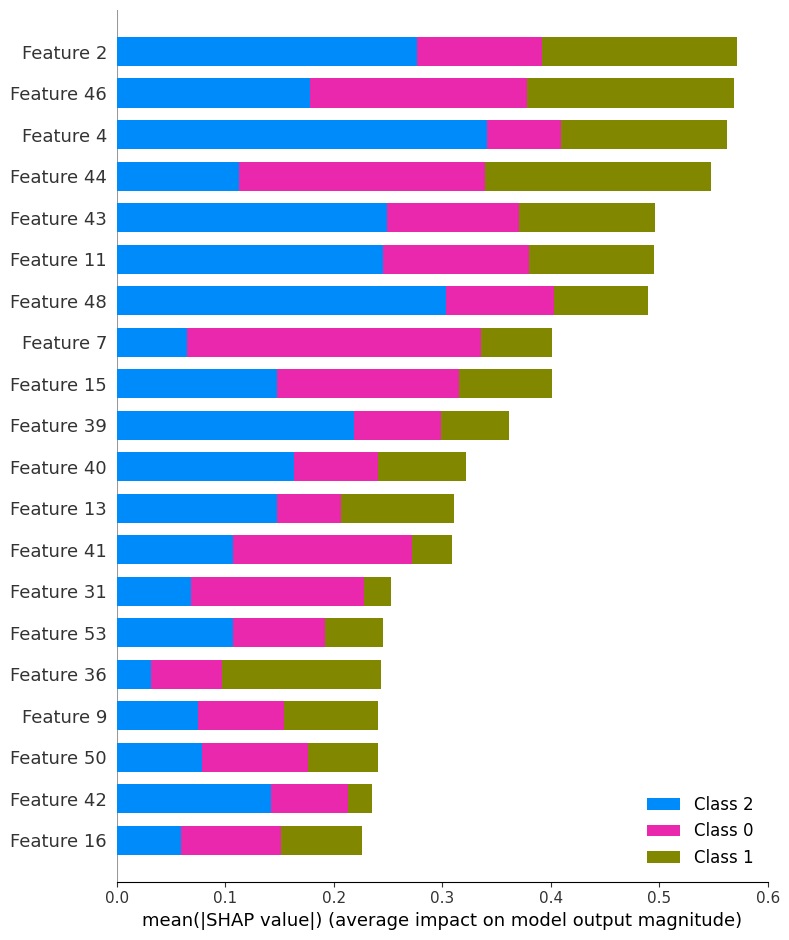

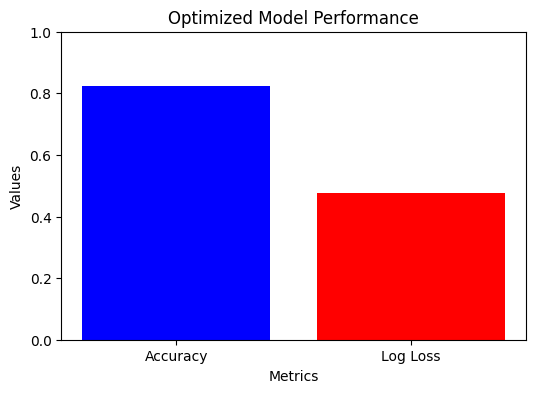

In [21]:
# Feature Importance with SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Plot accuracy and loss
metrics = ['Accuracy', 'Log Loss']
values = [accuracy, loss]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['blue', 'red'])
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Optimized Model Performance")
plt.ylim(0, 1)
plt.show()